# Generate power spectram from Sleep EEG data

This notebook produces the power spectra of the EEG data (in sleep stage N3).

In [1]:
# change into the root directory of the project
import os
if os.getcwd().split("/")[-1] == "dev":
    os.chdir('..')

In [76]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'plasma'
import tqdm
import logging
import neurolib.utils.functions as func

In [39]:
#plt.style.use("paper")
plt.style.reload_library()

In [88]:
#!ls /Volumes/fastio/GW-EEG/NAP_025/NAP_025_T1_postICAfilt_segStage_10sec_ICAsubtr_artfRem_N1.mat

from neurolib.utils.load_eeg_mat import MatDataset
import glob
import os
import scipy
import dill

class EEG_Dataset():
    def load_eeg_data(self, sleep_stage):
        
        EEG_DATA_DIR = "/Volumes/fastio/GW-EEG"
        filename_str = f"/NAP_*/NAP_*_T*_postICAfilt_segStage_10sec_ICAsubtr_artfRem_{sleep_stage}.mat"
        glob_path = EEG_DATA_DIR + "/" + filename_str
        filenames = glob.glob(glob_path)

        self.datasets = []
        self.filenames = []
        for f in filenames:
            eeg_data = MatDataset(MatDataset.load(f))
            self.datasets.append(eeg_data)
            self.filenames.append(f.split("/")[-1])
        
        self.ndatasets = len(self.datasets)
        self.subjects = np.unique([fname[:7] for fname in eeg.filenames])
        self.nsubjects = len(self.subjects)
        
        assert self.ndatasets > 0, f"No data found with sleep stage {sleep_stage}"
        
        print(f"{self.nsubjects} subjects with {self.ndatasets} datasets of sleep stage {sleep_stage} loaded.")
        print(f"Total of {np.sum([self.n_epochs(s) for s in range(self.ndatasets)])} epochs")
        
        
        self.fs = self.datasets[0].samplingRate
        print(f"Sampling rate: {self.fs} Hz")
        
    def n_epochs(self, subject_nr):
        return len(self.datasets[subject_nr].epochs)
    
    def get_epoch(self, epoch_nr, subject_nr = 0):
        e = self.datasets[subject_nr].epochs[epoch_nr]
        t = np.linspace(e[0], e[1], e[1] - e[0] + 1)
        t /= self.datasets[subject_nr].samplingRate
        data = self.datasets[subject_nr].data[epoch_nr]
        return t, data

In [93]:
# printing stats
stages = ["Wa", "N1", "N2", "N3", "N4"]
for stage in stages:
    print(f"Stage {stage}")
    eeg = EEG_Dataset()
    eeg.load_eeg_data(stage)
    print("------------")

Stage Wa
18 subjects with 53 datasets of sleep stage Wa loaded.
Total of 4577 epochs
Sampling rate: 500 Hz
------------
Stage N1
18 subjects with 55 datasets of sleep stage N1 loaded.
Total of 6937 epochs
Sampling rate: 500 Hz
------------
Stage N2
18 subjects with 55 datasets of sleep stage N2 loaded.
Total of 13342 epochs
Sampling rate: 500 Hz
------------
Stage N3
14 subjects with 29 datasets of sleep stage N3 loaded.
Total of 1034 epochs
Sampling rate: 500 Hz
------------
Stage N4
2 subjects with 2 datasets of sleep stage N4 loaded.
Total of 191 epochs
Sampling rate: 500 Hz
------------


In [96]:
def eeg_powerspec(eeg, channels=None, epochs=None, subject = 0, maxfr = 20, windowsize = 10, plot=False, print_channelwise=True):
    
    if channels is not None:
        channels = [channels] if isinstance(channels, (int, float)) else channels
    else:
        if len(eeg.datasets[subject].data) > 0:
            channels = range(eeg.datasets[subject].data[0].shape[0])
        else:
            logging.warn("Error, no data found")
            return None, None
    if epochs is not None:
        epochs = [epochs] if isinstance(epochs, (int, float)) else epochs
    else:
        epochs = range(len(eeg.datasets[subject].epochs))
    
    #print("Channels:", channels)
    #print("Epochs:", epochs)
    
    mean_power = []
    
    if plot:
        fig, axs = plt.subplots(len(channels), 2, figsize=(10, len(channels) * 2.1), dpi=150)
    
    for ci, channel in enumerate(channels):
        Ps = []
        domfrs = []
        for epoch in epochs:
            if plot:
                if axs.ndim == 1:
                    ax0 = axs[0]
                    ax1 = axs[1]
                else:
                    ax0 = axs[ci, 0]
                    ax1 = axs[ci, 1]
            eeg_t, eeg_data = eeg.get_epoch(epoch, subject)

            f, P = func.getPowerSpectrum(eeg_data[channel], dt=1/eeg.fs*1000, maxfr=maxfr, spectrum_windowsize=windowsize)
            Ps.append(P)
            #print(P.shape)
            domfrs.append(f[np.argmax(P)])
            #print(f"Dominant frequency: {f[np.argmax(P)]} Hz")
            
            if plot:
                ax0.set_title(f"Channel {channel}")
                ax0.plot(eeg_t, eeg_data[channel], lw=1, alpha=0.8);            
                ax1.set_title(f"Domfr: {f[np.argmax(np.mean(Ps, axis=0))]:.2f}")
                ax1.semilogy(f, P)
                #ax1.plot(f, P)
            
        # add mean power spectrum of this channel to list
        mean_power.append(np.mean(Ps, axis=0))
        if plot:
            ax1.plot(f, np.mean(Ps, axis=0), c='k', zorder=50)
        if print_channelwise:
            logging.info(f"Channel {channel}: Dominant frequency of mean power: {f[np.argmax(np.mean(Ps, axis=0))]:.2f} Hz, mean of dominant frequencies {np.mean(domfrs):.2f}")
    
    if plot:
        plt.show()
    # take mean over all channels and return
    return f, np.mean(mean_power, axis=0)

In [101]:
eeg = EEG_Dataset()
stage = "Wa"
eeg.load_eeg_data(stage)

18 subjects with 53 datasets of sleep stage Wa loaded.
Total of 4577 epochs
Sampling rate: 500 Hz


In [102]:
# get mean of all means
def get_powerspectra_all_subjects(stage):
    eeg = EEG_Dataset()
    eeg.load_eeg_data(stage)
    powerspecs = []
    fs = []
    for s in tqdm.tqdm(range(eeg.ndatasets)):
        #print(f"Dataset {s}")
        f, mean_eeg_power = eeg_powerspec(eeg, subject=s, maxfr = 40, plot=False, windowsize=10, print_channelwise=False)
        if mean_eeg_power is not None:
            fs.append(f)
            powerspecs.append(mean_eeg_power)
        else:
            logging.warn("No power spectrum returned, skipping subject.")
        # assume that all f's are the same, so we return only the first one
        f = fs[0]
    return f, powerspecs

In [103]:
def plot_powerspectra(f, powerspecs, mean_power, savename=None, logx = False, logy = True, maxfr = None, nxticks=5):
    plt.figure(figsize=(3, 3), dpi=300)

    plt.title(f"Sleep stage: {stage}")

    plt.plot(f, mean_power, c='k', zorder=5)

    if logy:
        plt.yscale('log',basey=2) 
    if logx:
        plt.xscale('log',basex=2) 
        
    for power in powerspecs:
        plt.plot(f, power, lw=1)
    plt.xlim(-1, 15)
    plt.xlabel("Frequency [Hz]")
    #plt.ylabel("Log power [mV$^2$]")
    plt.ylabel("Log power" if logy else "Power")
    plt.yticks([])
    #plt.xticks(np.linspace(0, 40, 81), fontsize=5)
    #plt.xlim(0, 5)
    
    if maxfr is None:
        maxfr = f[-1] + f[1]
   
    
    if not logx:
        plt.xticks(np.linspace(0, maxfr, nxticks), fontsize=12)

    plt.xlim(-0.5, maxfr+0.5) 
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    plt.tight_layout()
    if savename:
        plt.savefig(f"./data/figures/gw_eeg/{savename}.svg")
        plt.savefig(f"./data/figures/gw_eeg/{savename}.pdf")
        plt.savefig(f"./data/figures/gw_eeg/{savename}.png")

    plt.show()

In [104]:
stages = ["Wa", "N1", "N2", "N3", "N4"]
spectra = {}
for stage in stages:
    print(f"> Processing stage {stage}")
    f, powerspecs = get_powerspectra_all_subjects(stage)
    spectra[stage] = {}
    spectra[stage]["powerspecs"] = powerspecs
    mean_power = np.mean(powerspecs, axis=0)
    spectra[stage]["mean_power"] = mean_power

    
    plot_powerspectra(f, powerspecs, mean_power, savename=f"eeg_log_power_{stage}")
    plot_powerspectra(f, powerspecs, mean_power, savename=f"eeg_power_{stage}", logy=False)
    plot_powerspectra(f, powerspecs, mean_power, savename=f"eeg_15Hz_log_power_{stage}", maxfr = 15)
    plot_powerspectra(f, powerspecs, mean_power, savename=f"eeg_15Hz_power_{stage}", logy=False, maxfr = 15)    
    
    dill.dump((f, mean_power), open(f"./data/mean_eeg_power_{stage}.dill", "wb+"))
    
dill.dump((f, spectra), open(f"./data/all_stage_eeg_power_pectra.dill", "wb+"))

> Processing stage Wa


  0%|          | 0/53 [00:00<?, ?it/s]

18 subjects with 53 datasets of sleep stage Wa loaded.
Total of 4577 epochs
Sampling rate: 500 Hz


 13%|█▎        | 7/53 [00:14<02:11,  2.86s/it]

NameError: name 'logging' is not defined

53 subjects with sleep stage Wa loaded.
Total of 4577 epochs
Sampling rate: 500 Hz
Subject 0
Channels: range(0, 28)
Epochs: range(0, 136)
Subject 1
Channels: range(0, 28)
Epochs: range(0, 78)
Subject 2
Channels: range(0, 26)
Epochs: range(0, 126)
Subject 3
Channels: range(0, 28)
Epochs: range(0, 3)
Subject 4
Channels: range(0, 26)
Epochs: range(0, 3)
Subject 5
Channels: range(0, 26)
Epochs: range(0, 120)
Subject 6
Channels: range(0, 28)
Epochs: range(0, 307)
Subject 7
Error, no data found
No power spectrum returned, skipping subject.
Subject 8
Channels: range(0, 28)
Epochs: range(0, 83)
Subject 9
Channels: range(0, 28)
Epochs: range(0, 14)
Subject 10
Channels: range(0, 26)
Epochs: range(0, 10)
Subject 11
Channels: range(0, 28)
Epochs: range(0, 28)
Subject 12
Channels: range(0, 28)
Epochs: range(0, 25)
Subject 13
Channels: range(0, 28)
Epochs: range(0, 28)
Subject 14
Channels: range(0, 26)
Epochs: range(0, 26)
Subject 15
Channels: range(0, 26)
Epochs: range(0, 10)
Subject 16
Channels: r

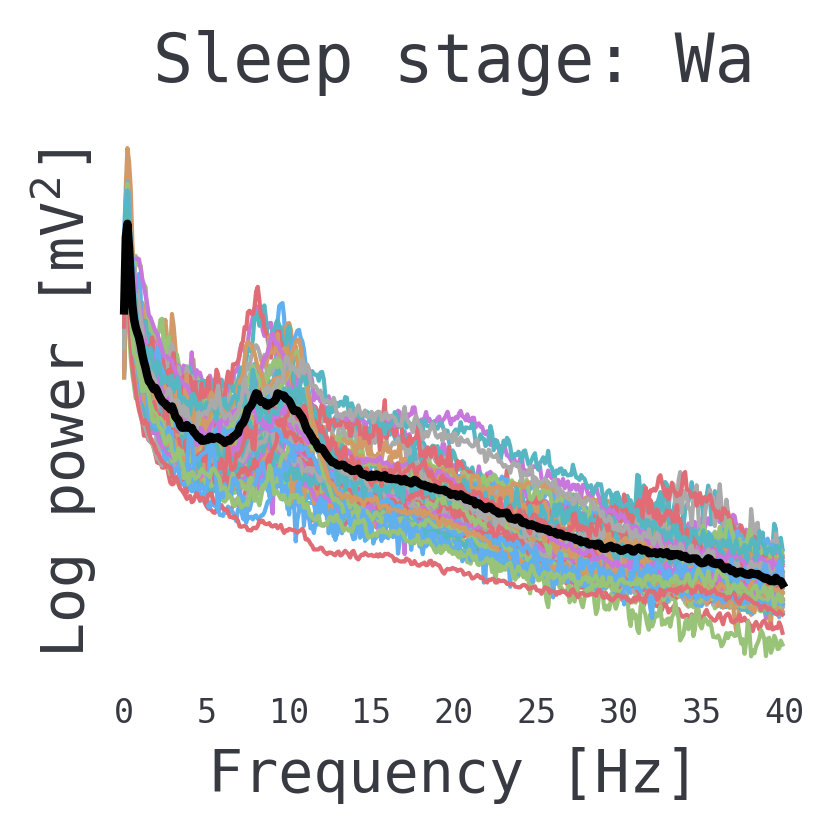

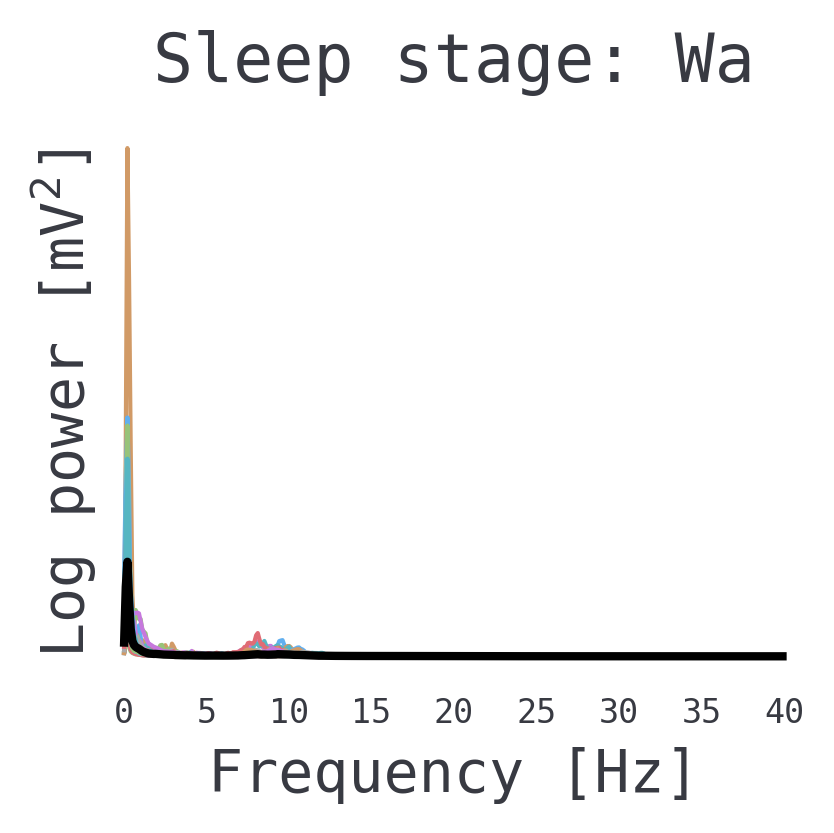

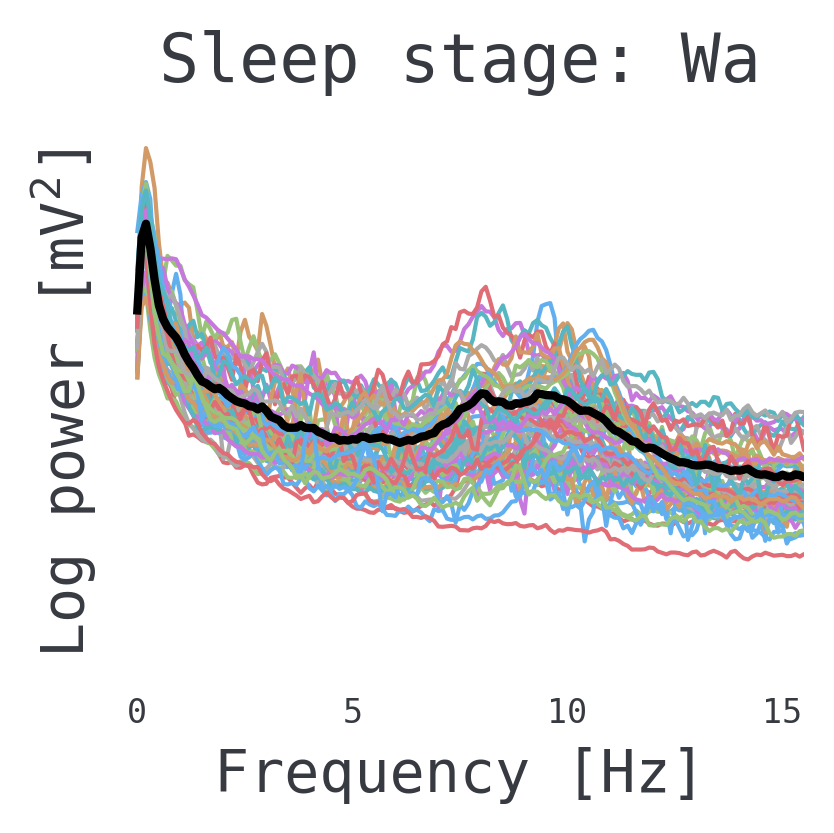

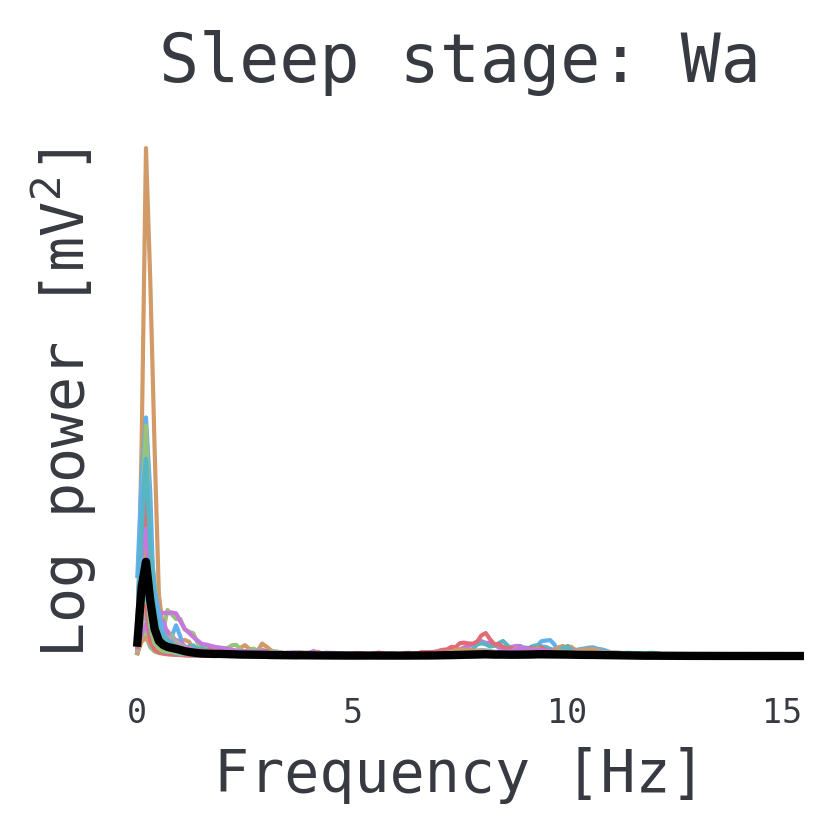

In [20]:
stages = ["Wa"]
spectra = {}
for stage in stages:
    
    f, powerspecs = get_powerspectra_all_subjects(stage)
    spectra[stage] = {}
    spectra[stage]["powerspecs"] = powerspecs
    mean_power = np.mean(powerspecs, axis=0)
    spectra[stage]["mean_power"] = mean_power

    
    plot_powerspectra(f, powerspecs, mean_power, savename=f"eeg_log_power_{stage}")
    plot_powerspectra(f, powerspecs, mean_power, savename=f"eeg_power_{stage}", logy=False)
    plot_powerspectra(f, powerspecs, mean_power, savename=f"eeg_15Hz_log_power_{stage}", maxfr = 15, nxticks=4)
    plot_powerspectra(f, powerspecs, mean_power, savename=f"eeg_15Hz_power_{stage}", logy=False, maxfr = 15, nxticks=4)    
    
    #dill.dump((f, mean_eeg_power), open(f"./data/mean_eeg_power_{stage}.dill", "wb+"))

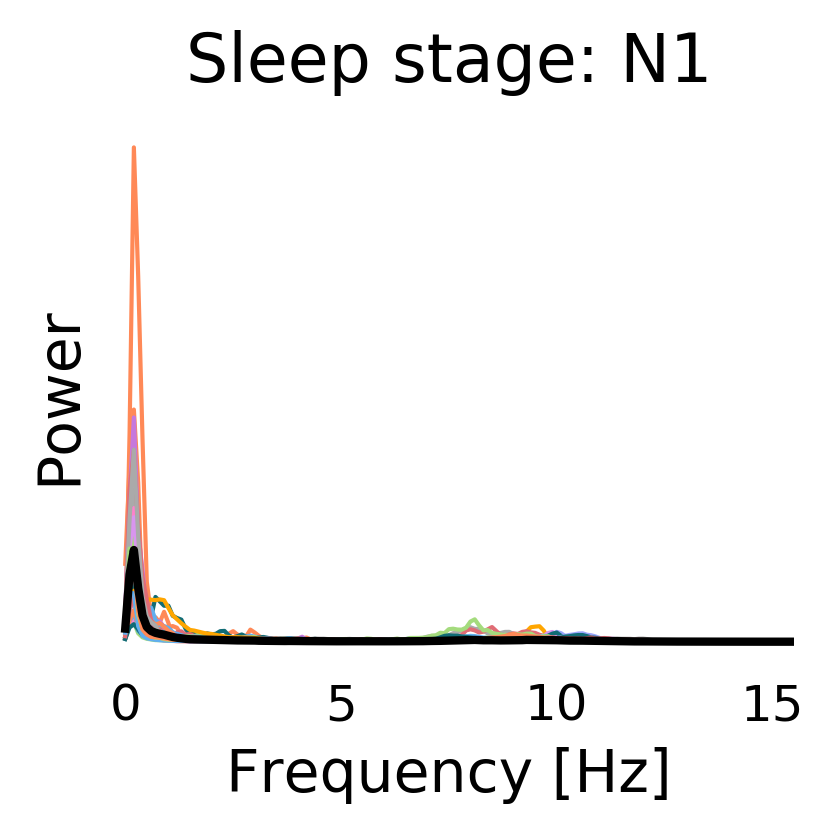

In [84]:
plot_powerspectra(f, powerspecs, mean_power, savename=f"eeg_15Hz_power_{stage}", logy=False, maxfr = 15, nxticks=4)    

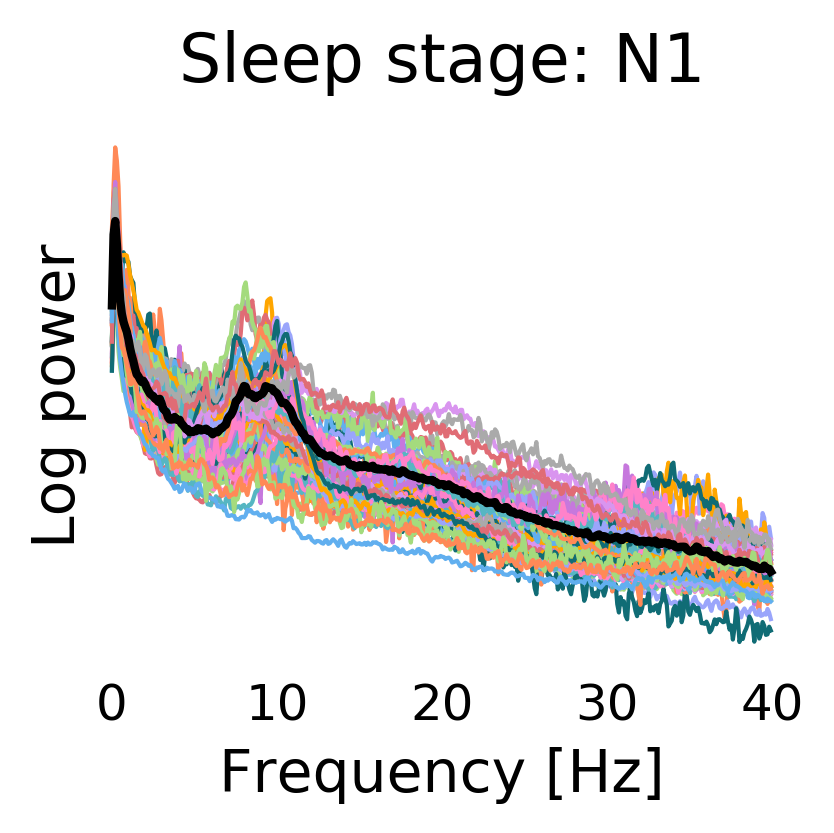

In [85]:
plot_powerspectra(f, powerspecs, mean_power, logy=True, maxfr = 40)    

In [ ]:
plot_powerspectra(f, powerspecs, mean_power, savename=f"eeg_power_{stage}")